## **GNN AND LSTM PROJECT USING TENSORFLOW AND KERAS**

- This traffic prediction project uses data on distances between nodes (monitoring points) and historical traffic speed data.
- The data is normalised and then fed into a combined GNN and LSTM model.
- GNNs allow the model to consider the spatial structure of the road network, while LSTMs capture temporal dependencies in traffic speeds, allowing for more accurate predictions of future speeds on the traffic network.

In [42]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops

### CREATE THE DATASEET BY GENERATING SYNTHETIC DATA

- **Distance Array (route_distances)**: An array of size 100×100 representing the distances between 100 monitoring points.

- **Speeds array (speeds_array)**: An array of size 200×100 representing the speeds recorded at 100 monitoring points over 200 time steps.

In [3]:
N = 100 # Number of nodes (control points)
T = 200 # Number of time steps

# Generating a random symmetric distance matrix
route_distances = np.random.rand(N, N) * 10000
route_distances = (route_distances + route_distances.T) / 2
np.fill_diagonal(route_distances, 0)

# Generate random speeds in the range [20, 80] km/h
speeds_matrix = np.random.uniform(20, 80, size=(T, N))

In [4]:
route_distances

array([[   0.        , 6543.34894579, 7897.80513732, ..., 2356.8486083 ,
        4167.95508225, 3913.33589263],
       [6543.34894579,    0.        , 2926.11787321, ..., 1958.87142925,
        6541.59735074, 5721.92279121],
       [7897.80513732, 2926.11787321,    0.        , ..., 7678.29383458,
        6459.30175412, 4111.2208314 ],
       ...,
       [2356.8486083 , 1958.87142925, 7678.29383458, ...,    0.        ,
        2502.66800535, 5274.38477977],
       [4167.95508225, 6541.59735074, 6459.30175412, ..., 2502.66800535,
           0.        , 5485.74515665],
       [3913.33589263, 5721.92279121, 4111.2208314 , ..., 5274.38477977,
        5485.74515665,    0.        ]])

In [5]:
speeds_matrix

array([[76.33801196, 52.84343083, 65.72824296, ..., 20.32838103,
        66.55260653, 62.66785163],
       [74.54707121, 64.45791818, 77.39567767, ..., 50.42284532,
        24.7379566 , 21.67875237],
       [70.73185116, 33.61255392, 42.57726273, ..., 21.41579346,
        31.70876124, 21.36875695],
       ...,
       [49.13584649, 29.91811692, 78.3212137 , ..., 63.66010486,
        43.9567523 , 43.14749904],
       [79.99233755, 20.49008707, 38.31272505, ..., 57.11997385,
        66.42832009, 42.49099348],
       [48.80156801, 33.02115961, 54.5535985 , ..., 50.19763306,
        25.93179338, 65.19144607]])

In [9]:
print("Route Distances", route_distances.shape)
print("Speed Matrix", speeds_matrix.shape)

Route Distances (100, 100)
Speed Matrix (200, 100)


### DATA NORMALISATION

In [17]:
from sklearn.preprocessing import StandardScaler

# Route_distances
route_distances_n = route_distances / np.max(route_distances)

# Speeds_array
scaler = StandardScaler()
speeds_matrix_n = scaler.fit_transform(speeds_matrix.reshape(-1, N)).reshape(T, N, 1)


### CONSTRUCTION OF THE MODEL

In [31]:
from sklearn.model_selection import train_test_split

# Split data into training and test
X = speeds_matrix_n[:-1]
y = speeds_matrix_n[1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Expands the adjacency matrix to match the number of samples in X_train and X_test
route_distances_expanded_train = np.expand_dims(route_distances_n, axis=0)
route_distances_expanded_train = np.repeat(route_distances_expanded_train, X_train.shape[0], axis=0)

route_distances_expanded_test = np.expand_dims(route_distances_n, axis=0)
route_distances_expanded_test = np.repeat(route_distances_expanded_test, X_test.shape[0], axis=0)


In [43]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

class GNNLayer(layers.Layer):
    def __init__(self, units):
        super(GNNLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    trainable=True)
        
    def call(self, inputs, adjacency_matrix):
        x = K.dot(inputs, self.kernel)
        x = K.batch_dot(adjacency_matrix, x)
        return K.relu(x + self.bias)

def build_model(num_nodes, num_features):
    node_features_input = tf.keras.Input(shape=(num_nodes, num_features))
    adj_matrix_input = tf.keras.Input(shape=(num_nodes, num_nodes))

    x = GNNLayer(32)(node_features_input, adj_matrix_input)
    x = GNNLayer(64)(x, adj_matrix_input)

    x = layers.Flatten()(x)
    x = layers.RepeatVector(T-1)(x)  # I use T-1 timesteps to predict the next

    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(64)(x)

    output = layers.Dense(num_nodes)(x)

    model = tf.keras.Model(inputs=[node_features_input, adj_matrix_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Model
num_nodes = route_distances_n.shape[0]
num_features = speeds_matrix_n.shape[2]
model = build_model(num_nodes, num_features)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 100, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_layer_4         │ (None, 100, 32)   │         64 │ input_layer_4[0]… │
│ (GNNLayer)          │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gnn_layer_5         │ (None, 100, 64)   │      2,112 │ gnn_layer_4[0][0… │
│ (GNNLayer)          │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 6400)      │          0 │ gnn_layer_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_2     │ (None, 199, 6400) │          0 │ flatten_2[0][0]   │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 199, 128)  │  3,342,848 │ repeat_vector_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     49,408 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 100)       │      6,500 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,400,932 (12.97 MB)

 Trainable params: 3,400,932 (12.97 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='gnn_lstm_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### TRAIN THE MODEL

In [32]:
model.fit([X_train, route_distances_expanded_train], y_train, epochs=10, batch_size=32)

Epoch 1/10


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - loss: 0.9936
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.9961
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.9931
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.9999
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.9896
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.9924
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - loss: 0.9956
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.9845
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - loss: 0.9903
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - loss: 0.9881


### MODEL EVALUATION

In [46]:
loss = model.evaluate([X_test, route_distances_expanded_test], y_test)
print(f'Loss in test data: {loss}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - loss: 1.0734
Loss in test data: 1.0720598697662354


### MAKE PREDICTIONS

In [47]:
predictions = model.predict([X_test, route_distances_expanded_test])

print(f'Shape of y_test: {y_test.shape}')
print(f'Shape of predictions: {predictions.shape}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step
Shape of y_test: (40, 100, 1)
Shape of predictions: (40, 100)


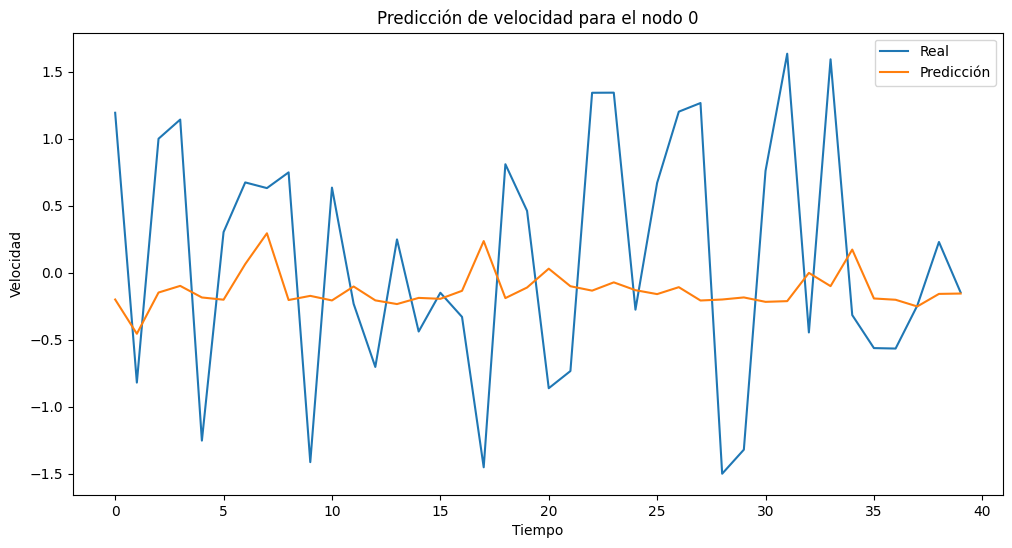

In [49]:
import matplotlib.pyplot as plt

# Seleccionar un nodo para visualizar
node_index = 0  # Cambiar a cualquier nodo para ver sus resultados

plt.figure(figsize=(12, 6))

# Deshacerse de la dimensión adicional en y_test si existe
y_test_reshaped = y_test.squeeze(axis=-1)

plt.plot(y_test_reshaped[:, node_index], label='Real')
plt.plot(predictions[:, node_index], label='Predicción')

plt.title(f'Predicción de velocidad para el nodo {node_index}')
plt.xlabel('Tiempo')
plt.ylabel('Velocidad')
plt.legend()
plt.show()

-------------